In [1]:
import pandas as pd

# df = pd.read_parquet("data/eurosat_rgb/initial_samples.parquet")
df = pd.read_parquet("active_labeled.parquet")
df


,filename,filepath,label
0,AnnualCrop_2216.tif,data/eurosat_rgb/0/AnnualCrop_2216.jpg,Annual Crop
1,AnnualCrop_1331.tif,data/eurosat_rgb/0/AnnualCrop_1331.jpg,Annual Crop
2,AnnualCrop_631.tif,data/eurosat_rgb/0/AnnualCrop_631.jpg,Annual Crop
3,AnnualCrop_2904.tif,data/eurosat_rgb/0/AnnualCrop_2904.jpg,Annual Crop
4,AnnualCrop_1963.tif,data/eurosat_rgb/0/AnnualCrop_1963.jpg,Annual Crop
...,...,...,...
983,None,data/eurosat_rgb/4/Industrial_2206.jpg,Industrial Buildings
984,None,data/eurosat_rgb/6/PermanentCrop_607.jpg,Permanent Crop
985,None,data/eurosat_rgb/0/AnnualCrop_621.jpg,Annual Crop
986,None,data/eurosat_rgb/6/PermanentCrop_1157.jpg,Permanent Crop


In [2]:
df["label"].value_counts()

label
Herbaceous Vegetation    173
Highway                  139
Permanent Crop           126
Pasture                  116
Annual Crop              114
River                    110
SeaLake                   66
Forest                    59
Industrial Buildings      45
Residential Buildings     40
Name: count, dtype: int64

In [3]:
from active_vision import ActiveLearner
from fastai.vision.models.all import resnet18
from fastai.vision.all import aug_transforms

al = ActiveLearner(resnet18)

2025-01-22 13:14:29.476 | INFO     | active_vision.core:load_model:39 - Loading fastai model resnet18


In [4]:
al.load_dataset(df, filepath_col="filepath", label_col="label", 
                batch_size=16,
                image_size=64,
                batch_tfms=aug_transforms(size=64))

2025-01-22 13:14:29.483 | INFO     | active_vision.core:load_dataset:57 - Loading dataset from filepath and label
2025-01-22 13:14:29.486 | INFO     | active_vision.core:load_dataset:60 - Creating dataloaders
2025-01-22 13:14:29.981 | INFO     | active_vision.core:load_dataset:82 - Creating learner
2025-01-22 13:14:30.144 | INFO     | active_vision.core:load_dataset:89 - Done. Ready to train.


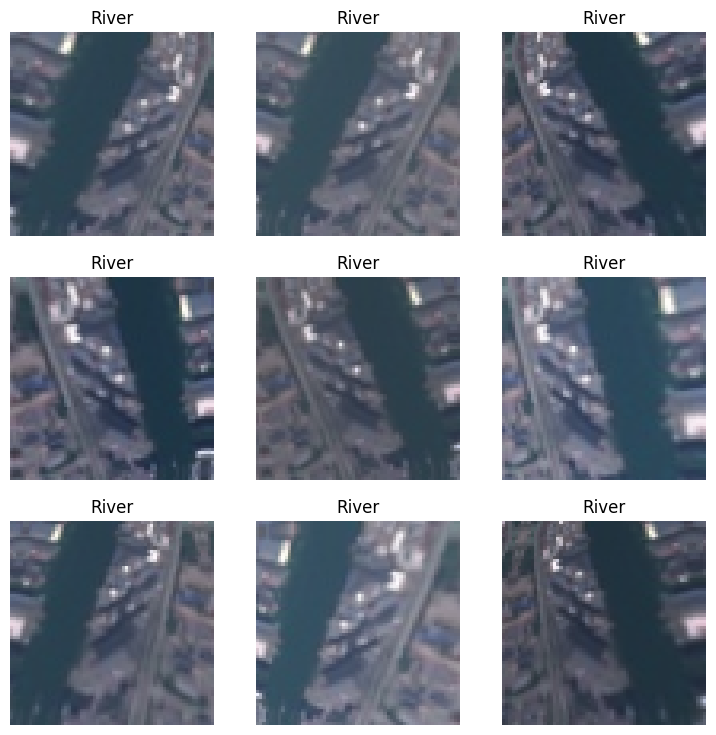

In [5]:
al.show_batch(unique=True)

In [6]:
# al.train_set

In [7]:
# al.lr_find()

2025-01-22 13:14:30.726 | INFO     | active_vision.core:train:125 - Training head for 3 epochs
2025-01-22 13:14:30.727 | INFO     | active_vision.core:train:126 - Training model end-to-end for 10 epochs
2025-01-22 13:14:30.728 | INFO     | active_vision.core:train:127 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,3.167962,2.058832,0.380711,00:03
1,2.491228,2.092621,0.416244,00:03
2,2.217579,2.539173,0.345178,00:03


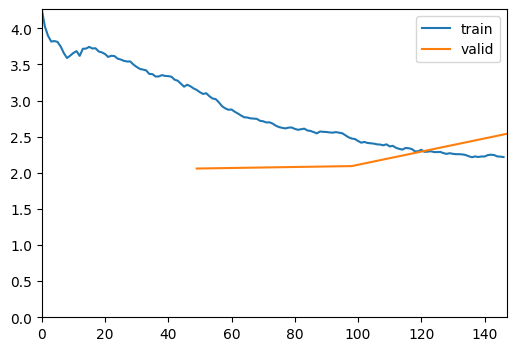

epoch,train_loss,valid_loss,accuracy,time
0,1.796639,1.984588,0.477157,00:03
1,1.539800,1.908257,0.487310,00:04
2,1.450132,2.283095,0.482233,00:03
3,1.327780,1.125232,0.634518,00:03
4,1.127071,1.160908,0.639594,00:03
5,0.938986,1.241246,0.629442,00:03
6,0.758540,1.057890,0.700508,00:03
7,0.582778,1.046731,0.700508,00:03
8,0.538877,0.994910,0.700508,00:03
9,0.502944,0.960770,0.736041,00:03


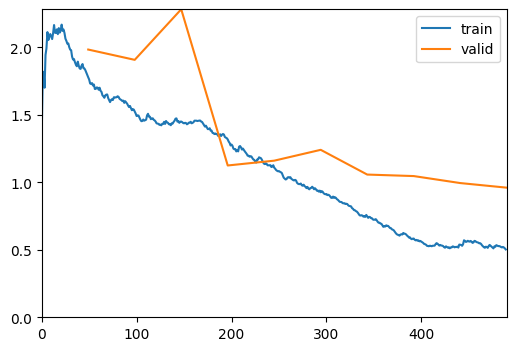

In [8]:
al.train(epochs=10, lr=5e-3, head_tuning_epochs=3)

## Evaluate the model on a *labeled* evaluation set

In [9]:
evaluation_df = pd.read_parquet("data/eurosat_rgb/evaluation_samples.parquet")
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")


2025-01-22 13:15:23.546 | INFO     | active_vision.core:evaluate:172 - Accuracy: 91.43%


0.9142592592592592

## Get the predictions from an *unlabeled* set

In [10]:
df = pd.read_parquet("data/eurosat_rgb/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

16100

In [11]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-01-22 13:15:23.577 | INFO     | active_vision.core:predict:136 - Running inference on 16100 samples


,filepath,pred_label,pred_conf,pred_raw
0,data/eurosat_rgb/0/AnnualCrop_1.jpg,Permanent Crop,0.971075,"[0.026856636628508568, 5.583980600931682e-05, 0.0010110322618857026, 3.6620640457840636e-05, 5.144203896634281e-05, 0.0006245539989322424, 0.9710748791694641, 9.028358908835799e-05, 0.00011672161053866148, 8.204374898923561e-05]"
1,data/eurosat_rgb/0/AnnualCrop_10.jpg,Annual Crop,0.999729,"[0.9997290968894958, 3.5753916449721146e-07, 1.8977427268529468e-11, 1.032555246638367e-06, 1.259992643554142e-07, 2.625160277602845e-06, 6.287276050898072e-07, 9.326966221578914e-08, 0.00024536321870982647, 2.0578028852469288e-05]"
2,data/eurosat_rgb/0/AnnualCrop_100.jpg,Annual Crop,0.999927,"[0.9999265670776367, 1.3733334469634428e-07, 2.60612893043799e-07, 3.2049851142801344e-05, 4.296780389267951e-07, 1.794934291865502e-06, 1.7152955479105003e-05, 1.8810749224940082e-06, 1.063362378772581e-05, 9.059960575541481e-06]"
3,data/eurosat_rgb/0/AnnualCrop_1000.jpg,Annual Crop,0.999741,"[0.9997406601905823, 1.2455136584321735e-06, 1.0145751048185048e-06, 7.956906301842537e-06, 4.263185928721214e-06, 1.6215286450460553e-05, 0.0001574946945765987, 1.1769277534767753e-06, 6.599102198379114e-05, 3.7769736991322134e-06]"
4,data/eurosat_rgb/0/AnnualCrop_1001.jpg,Annual Crop,0.998711,"[0.9987112283706665, 1.3346658533919253e-07, 3.7578135447802197e-07, 8.652269798403722e-07, 1.0904463124461472e-05, 2.928891990450211e-05, 0.00122548989020288, 5.362634055927629e-06, 2.973119080706965e-06, 1.346685803582659e-05]"
...,...,...,...,...
16095,data/eurosat_rgb/9/SeaLake_993.jpg,SeaLake,0.993569,"[0.0014684597263112664, 0.0011397353373467922, 0.00012812475324608386, 0.0006644771783612669, 0.00016580575902480632, 0.000959519122261554, 1.8730494048213586e-05, 0.00017478405789006501, 0.0017109453910961747, 0.9935693740844727]"
16096,data/eurosat_rgb/9/SeaLake_994.jpg,SeaLake,0.998270,"[0.0004337934369686991, 0.00029989363974891603, 7.2554162215965334e-06, 2.695713919820264e-05, 6.587789539480582e-05, 0.0003028366481885314, 8.140351042129623e-07, 3.6239391192793846e-05, 0.0005559150013141334, 0.9982703924179077]"
16097,data/eurosat_rgb/9/SeaLake_995.jpg,SeaLake,0.998558,"[0.0002583465538918972, 0.0001720119034871459, 7.257507149915909e-06, 3.4827098716050386e-05, 5.4231764806900173e-05, 0.00015083944890648127, 1.0173412192671094e-06, 3.3118856663350016e-05, 0.0007302336161956191, 0.9985581040382385]"
16098,data/eurosat_rgb/9/SeaLake_996.jpg,SeaLake,0.998430,"[8.728794637136161e-05, 0.0004945198888890445, 3.791049311985262e-05, 4.8678037273930386e-05, 6.537564331665635e-05, 0.00019403536862228066, 2.3976422198757064e-06, 4.771321619045921e-05, 0.0005924410652369261, 0.9984295964241028]"


In [12]:
uncertain_df = al.sample_uncertain(pred_df, num_samples=200)
uncertain_df

2025-01-22 13:15:27.959 | INFO     | active_vision.core:sample_uncertain:194 - Getting top 200 low confidence samples


,filepath,pred_label,pred_conf,pred_raw,uncertainty_score
15894,data/eurosat_rgb/9/SeaLake_698.jpg,River,0.238730,"[0.20459553599357605, 0.006825355347245932, 0.02078879065811634, 0.06856439262628555, 0.008687240071594715, 0.20559696853160858, 0.005935764871537685, 0.0029412878211587667, 0.23872968554496765, 0.2373349666595459]",0.761270
3189,data/eurosat_rgb/1/Forest_439.jpg,Forest,0.276834,"[0.03324120119214058, 0.27683427929878235, 0.19553957879543304, 0.027531025931239128, 0.012080385349690914, 0.23841312527656555, 0.12612661719322205, 0.0457693375647068, 0.021472616121172905, 0.022991804406046867]",0.723166
4495,data/eurosat_rgb/2/HerbaceousVegetation_2419.jpg,Herbaceous Vegetation,0.310191,"[0.0009256437188014388, 0.30898138880729675, 0.31019070744514465, 0.0005336329340934753, 0.001520178746432066, 0.08163240551948547, 0.26377010345458984, 0.0025808655191212893, 0.012723641470074654, 0.017141396179795265]",0.689809
11170,data/eurosat_rgb/7/Residential_1271.jpg,Highway,0.316407,"[0.020326245576143265, 0.003559875302016735, 0.009848346933722496, 0.3164072632789612, 0.21430104970932007, 0.011457801796495914, 0.06676119565963745, 0.14628340303897858, 0.20852063596248627, 0.002534209517762065]",0.683593
2193,data/eurosat_rgb/1/Forest_1657.jpg,Forest,0.316812,"[6.066495643608505e-06, 0.31681153178215027, 0.26060205698013306, 0.001065021031536162, 0.0005130026838742197, 4.2523068259470165e-05, 0.27958518266677856, 0.14058426022529602, 0.00012449499627109617, 0.0006658225902356207]",0.683188
...,...,...,...,...,...
8944,data/eurosat_rgb/5/Pasture_1939.jpg,Pasture,0.484976,"[0.06299684941768646, 0.0023675004485994577, 0.017138492316007614, 0.0008624907350167632, 0.0014109406620264053, 0.48497647047042847, 0.4246595799922943, 0.001809915411286056, 0.0005021047545596957, 0.003275733208283782]",0.515024
5519,data/eurosat_rgb/3/Highway_125.jpg,Highway,0.485306,"[0.009503637440502644, 0.00500073516741395, 0.31272590160369873, 0.4853062629699707, 0.0067489673383533955, 0.007569565437734127, 0.04303133487701416, 0.007090145722031593, 0.11172384768724442, 0.011299634352326393]",0.514694
10863,data/eurosat_rgb/6/PermanentCrop_825.jpg,Permanent Crop,0.485404,"[0.09765750914812088, 0.0007618168601766229, 0.3992827236652374, 0.0008062120759859681, 0.0008932673372328281, 0.005263584665954113, 0.4854043126106262, 0.0023396965116262436, 0.0003712798934429884, 0.007219540420919657]",0.514596
5564,data/eurosat_rgb/3/Highway_1319.jpg,Industrial Buildings,0.485776,"[6.871194386803836e-07, 1.180476010631537e-05, 3.4014877314803016e-07, 0.44057968258857727, 0.48577597737312317, 0.05711818486452103, 0.003955870866775513, 0.0003916842397302389, 0.012161163613200188, 4.659067599277478e-06]",0.514224


## Label the uncertain samples

In [13]:
al.label(uncertain_df, output_filename="uncertain")

2025-01-22 13:15:29.785 | INFO     | active_vision.core:label:275 - Launching labeling interface for 200 samples


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [14]:
labeled_df = pd.read_parquet("uncertain.parquet")

labeled_df


,filepath,label
0,data/eurosat_rgb/5/Pasture_1923.jpg,Pasture
1,data/eurosat_rgb/6/PermanentCrop_2202.jpg,Permanent Crop
2,data/eurosat_rgb/2/HerbaceousVegetation_1402.jpg,Herbaceous Vegetation
3,data/eurosat_rgb/2/HerbaceousVegetation_1445.jpg,Herbaceous Vegetation
4,data/eurosat_rgb/2/HerbaceousVegetation_1029.jpg,Herbaceous Vegetation
...,...,...
1105,data/eurosat_rgb/5/Pasture_1939.jpg,Pasture
1106,data/eurosat_rgb/3/Highway_125.jpg,Highway
1107,data/eurosat_rgb/6/PermanentCrop_825.jpg,Permanent Crop
1108,data/eurosat_rgb/3/Highway_1319.jpg,Highway


In [15]:
al.add_to_train_set(labeled_df, output_filename="active_labeled")

2025-01-22 13:22:46.631 | INFO     | active_vision.core:add_to_train_set:619 - Adding 1088 samples to training set
2025-01-22 13:22:46.635 | INFO     | active_vision.core:add_to_train_set:628 - Saved training set to active_labeled.parquet
